In [1]:
import anndata as ad
import torch
import pandas as pd
import requests
import sys
import os
import scanpy as sc
#import pertpy as pt      # comment-out when using nen_env
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pickle
from scipy.stats import wasserstein_distance, permutation_test
from scipy.spatial.distance import cdist, pdist, squareform

from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())

sys.path.append('../src/null-effect-net')

import utils            # comment-out when using pertpy_env

## Load perturbation screens

In [20]:
perturbation_screen_name = 'GasperiniShendure2019_atscale'

In [23]:
adata = sc.read_h5ad(f'../data/perturbation_screens/{perturbation_screen_name}.h5ad')
adata

AnnData object with n_obs × n_vars = 207324 × 13135
    obs: 'sample', 'total_umis', 'Size_Factor', 'gene', 'all_gene', 'barcode', 'read_count', 'umi_count', 'proportion', 'guide_count', 'sample_directory', 'ko_barcode_file', 'id', 'prep_batch', 'within_batch_chip', 'within_chip_lane', 'percent.mito', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [24]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 207324 × 13135
    obs: 'sample', 'total_umis', 'Size_Factor', 'gene', 'all_gene', 'barcode', 'read_count', 'umi_count', 'proportion', 'guide_count', 'sample_directory', 'ko_barcode_file', 'id', 'prep_batch', 'within_batch_chip', 'within_chip_lane', 'percent.mito', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'n_genes'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells'

In [25]:
adata.obs

,sample,total_umis,Size_Factor,gene,all_gene,barcode,read_count,umi_count,proportion,guide_count,...,perturbation_type,celltype,organism,perturbation,nperts,ngenes,ncounts,percent_mito,percent_ribo,n_genes
AAACCTGAGAGGTACC,1A_1_SI-GA-E2,17572,1.009682,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,AGAAAGCTCCTCCAGTTCAC_TGATCGCTTTGACTGTGACA_ACAA...,14135.0,964.0,0.969819,67.0,...,CRISPR,lymphoblasts,human,chr10.845_top_two_chr1.11183_top_two_chr1.1129...,195,3549,17566.0,0.0,30.507799,3549
AAACCTGAGTCAATAG,1A_1_SI-GA-E2,8923,0.939677,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,GTAGAGCCTCCAGAACTGTG_AGGTTTATCCAGATGAACTG_CATC...,4329.0,293.0,0.844380,26.0,...,CRISPR,lymphoblasts,human,chr1.12695_top_two_chr11.3294_top_two_chr1.679...,68,2543,8917.0,0.0,28.955927,2543
AAACCTGCAAACAACA,1A_1_SI-GA-E2,14637,0.990803,ALDH1A2_TSS_BRI3_TSS_chr10.1918_top_two_chr10....,ALDH1A2_TSS_BRI3_TSS_chr10.1918_top_two_chr10....,CCAAGGCGTCCTCAGACCAG_AGCTCCAGGAAGGACCCCCG_TCAC...,12362.0,884.0,0.950538,61.0,...,CRISPR,lymphoblasts,human,ALDH1A2_BRI3_chr10.1918_top_two_chr10.350_top_...,167,3191,14626.0,0.0,26.548612,3191
AAACCTGCACTTCTGC,1A_1_SI-GA-E2,22798,1.036578,C16orf91_TSS_chr1.11332_top_two_chr1.1933_top_...,C16orf91_TSS_chr1.11332_top_two_chr1.1933_top_...,GGCGTCAGTCGAGGAGTCAG_GCCAGCACTTCAGCTCACCG_GCTG...,7459.0,544.0,0.939551,39.0,...,CRISPR,lymphoblasts,human,C16orf91_chr1.11332_top_two_chr1.1933_top_two_...,109,4539,22783.0,0.0,20.616249,4539
AAACCTGCATGTAGTC,1A_1_SI-GA-E2,10136,0.952844,chr10.185_top_two_chr10.484_top_two_chr11.4167...,chr10.185_top_two_chr10.484_top_two_chr11.4167...,ATAAGGCACTCACATCCACC_GCTTGTCCCTAACACTCAGA_GGGC...,14831.0,1054.0,0.959927,37.0,...,CRISPR,lymphoblasts,human,chr10.185_top_two_chr10.484_top_two_chr11.4167...,107,2605,10124.0,0.0,32.418017,2605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTACCTACA,2B_8_SI-GA-H9,17938,1.011811,BRIX1_TSS_chr10.2059_top_two_chr10.350_top_two...,BRIX1_TSS_chr10.2059_top_two_chr10.350_top_two...,AGGAGGCCAAGAGCGCGGGG_TGATTGAAGGAGGCTCCCCA_GGTA...,4570.0,394.0,0.856522,31.0,...,CRISPR,lymphoblasts,human,BRIX1_chr10.2059_top_two_chr10.350_top_two_chr...,85,3451,17934.0,0.0,31.733021,3451
TTTGTCAGTATCACCA-1,2B_8_SI-GA-H9,16543,1.003448,chr10.221_top_two_chr11.3853_top_two_chr11.498...,chr10.221_top_two_chr11.3853_top_two_chr11.498...,CCTGCAACTGTCTATGGCCT_TCAGTGGGTGAGTCTTCAGG_TGAG...,4311.0,387.0,0.861915,33.0,...,CRISPR,lymphoblasts,human,chr10.221_top_two_chr11.3853_top_two_chr11.498...,92,3693,16542.0,0.0,24.694716,3693
TTTGTCAGTTCAGACT-1,2B_8_SI-GA-H9,15009,0.993396,chr12.3400_top_two_chr4.1281_second_two_ID3_TSS,chr12.3400_top_two_chr4.1281_second_two_ID3_TSS,CCAGTTGCTAGGCAGGACAG_CTTTCAGGCAGGAATCTGAG_TGGT...,669.0,57.0,0.876923,3.0,...,CRISPR,lymphoblasts,human,chr12.3400_top_two_chr4.1281_second_two_ID3,7,3162,14992.0,0.0,32.123799,3162
TTTGTCAGTTCTGTTT,2B_8_SI-GA-H9,5149,0.882878,chr7.1014_top_two,chr7.1014_top_two,CACCCCCCAGAGATAAGAGA,77.0,7.0,0.086420,1.0,...,CRISPR,lymphoblasts,human,chr7.1014_top_two,3,1392,5149.0,0.0,35.074772,1392


In [6]:
# only single perturbation
# no nan

valid_indices = adata.obs[(~adata.obs['perturbation'].str.contains('_')) & (~adata.obs['perturbation'].str.contains('nan'))].index
adata = adata[valid_indices, :]
adata

View of AnnData object with n_obs × n_vars = 310385 × 8563
    obs: 'batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id', 'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex', 'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type', 'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'n_genes'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells', 'n_cells'

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:216: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [29]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

In [8]:
adata.obs[adata.obs['perturbation'] != 'control']

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,age,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo,n_genes
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,ENSG00000145414,P1P2,5449_NAF1_P1P2_ENSG00000145414,NAF1_+_164087918.23-P1P2|NAF1_-_164087674.23-P1P2,0.112083,11438.0,0.013047,0.813253,...,53,NAF1,human,CRISPR,cell_line,11324.0,3332,1,0.225362,3332
AAACCCAAGAACTTCC-31,31,BUB1,ENSG00000169679,P1P2,935_BUB1_P1P2_ENSG00000169679,BUB1_-_111435363.23-P1P2|BUB1_-_111435372.23-P1P2,0.179895,5342.0,-1.522247,0.844107,...,53,BUB1,human,CRISPR,cell_line,5257.0,2192,1,0.129732,2192
AAACCCAAGAAGCCAC-34,34,UBL5,ENSG00000198258,P1P2,9534_UBL5_P1P2_ENSG00000198258,UBL5_-_9938639.23-P1P2|UBL5_+_9938801.23-P1P2,0.105287,17305.0,0.384157,1.091537,...,53,UBL5,human,CRISPR,cell_line,17135.0,4002,1,0.236825,4002
AAACCCAAGAATAGTC-43,43,C9orf16,ENSG00000171159,P1P2,1131_C9orf16_P1P2_ENSG00000171159,C9orf16_+_130922603.23-P1P2|C9orf16_+_13092264...,0.099359,30244.0,3.721912,0.948277,...,53,C9orf16,human,CRISPR,cell_line,29717.0,5358,1,0.246828,5358
AAACCCAAGACAGCGT-28,28,TIMM9,ENSG00000100575,P1P2,8927_TIMM9_P1P2_ENSG00000100575,TIMM9_-_58893843.23-P1P2|TIMM9_-_58893848.23-P1P2,0.137623,8407.0,-0.975371,0.868942,...,53,TIMM9,human,CRISPR,cell_line,8261.0,2944,1,0.183392,2944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTGTCGTC-45,45,ATP6V1D,ENSG00000100554,P1P2,682_ATP6V1D_P1P2_ENSG00000100554,ATP6V1D_+_67826485.23-P1P2|ATP6V1D_+_67826497....,0.100272,18350.0,0.428227,1.115052,...,53,ATP6V1D,human,CRISPR,cell_line,18044.0,4300,1,0.253547,4300
TTTGTTGTCTGTCTCG-27,27,CNOT3,ENSG00000088038,P1P2,1718_CNOT3_P1P2_ENSG00000088038,CNOT3_+_54641532.23-P1P2|CNOT3_-_54641691.23-P1P2,0.093876,8671.0,-0.633593,0.813253,...,53,CNOT3,human,CRISPR,cell_line,8510.0,3158,1,0.183196,3158
TTTGTTGTCTGTGCGG-44,44,METTL3,ENSG00000165819,P1P2,5004_METTL3_P1P2_ENSG00000165819,METTL3_+_21979431.23-P1P2|METTL3_-_21979084.23...,0.107983,20568.0,1.054624,0.973352,...,53,METTL3,human,CRISPR,cell_line,20355.0,4247,1,0.256595,4247


In [9]:
adata.obs['gene_list'] = adata.obs['perturbation'].apply(utils.convert_genomic_location_to_ensembl_ids)
adata.obs

gene_string='AAAS'
gene_list=['AAAS']
match=None
['AAAS']:     ENSG00000094914
gene_string='AAMP'
gene_list=['AAMP']
match=None
['AAMP']:     ENSG00000127837
gene_string='AARS'
gene_list=['AARS']
match=None
['AARS']:     ENSG00000090861
gene_string='AARS2'
gene_list=['AARS2']
match=None
['AARS2']:     ENSG00000124608
gene_string='AASDHPPT'
gene_list=['AASDHPPT']
match=None
['AASDHPPT']:     ENSG00000149313
gene_string='AATF'
gene_list=['AATF']
match=None
['AATF']:     ENSG00000275700
gene_string='ABCB7'
gene_list=['ABCB7']
match=None
['ABCB7']:     ENSG00000131269
gene_string='ABCB10'
gene_list=['ABCB10']
match=None
['ABCB10']:     ENSG00000135776
gene_string='ABCE1'
gene_list=['ABCE1']
match=None
['ABCE1']:     ENSG00000164163
gene_string='ABCF1'
gene_list=['ABCF1']
match=None
['ABCF1']:     ENSG00000204574
gene_string='ABCG1'
gene_list=['ABCG1']
match=None
['ABCG1']:     ENSG00000160179
gene_string='ABHD11'
gene_list=['ABHD11']
match=None
['ABHD11']:     ENSG00000106077
gene_string='

,batch,gene,gene_id,transcript,gene_transcript,guide_id,percent_mito,UMI_count,z_gemgroup_UMI,core_scale_factor,...,perturbation,organism,perturbation_type,tissue_type,ncounts,ngenes,nperts,percent_ribo,n_genes,gene_list
cell_barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCAAGAAATCCA-27,27,NAF1,ENSG00000145414,P1P2,5449_NAF1_P1P2_ENSG00000145414,NAF1_+_164087918.23-P1P2|NAF1_-_164087674.23-P1P2,0.112083,11438.0,0.013047,0.813253,...,NAF1,human,CRISPR,cell_line,11324.0,3332,1,0.225362,3332,ENSG00000145901
AAACCCAAGAACTTCC-31,31,BUB1,ENSG00000169679,P1P2,935_BUB1_P1P2_ENSG00000169679,BUB1_-_111435363.23-P1P2|BUB1_-_111435372.23-P1P2,0.179895,5342.0,-1.522247,0.844107,...,BUB1,human,CRISPR,cell_line,5257.0,2192,1,0.129732,2192,ENSG00000169679
AAACCCAAGAAGCCAC-34,34,UBL5,ENSG00000198258,P1P2,9534_UBL5_P1P2_ENSG00000198258,UBL5_-_9938639.23-P1P2|UBL5_+_9938801.23-P1P2,0.105287,17305.0,0.384157,1.091537,...,UBL5,human,CRISPR,cell_line,17135.0,4002,1,0.236825,4002,ENSG00000198258
AAACCCAAGAATAGTC-43,43,C9orf16,ENSG00000171159,P1P2,1131_C9orf16_P1P2_ENSG00000171159,C9orf16_+_130922603.23-P1P2|C9orf16_+_13092264...,0.099359,30244.0,3.721912,0.948277,...,C9orf16,human,CRISPR,cell_line,29717.0,5358,1,0.246828,5358,ENSG00000171159
AAACCCAAGACAGCGT-28,28,TIMM9,ENSG00000100575,P1P2,8927_TIMM9_P1P2_ENSG00000100575,TIMM9_-_58893843.23-P1P2|TIMM9_-_58893848.23-P1P2,0.137623,8407.0,-0.975371,0.868942,...,TIMM9,human,CRISPR,cell_line,8261.0,2944,1,0.183392,2944,ENSG00000100575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGTCTGTCGTC-45,45,ATP6V1D,ENSG00000100554,P1P2,682_ATP6V1D_P1P2_ENSG00000100554,ATP6V1D_+_67826485.23-P1P2|ATP6V1D_+_67826497....,0.100272,18350.0,0.428227,1.115052,...,ATP6V1D,human,CRISPR,cell_line,18044.0,4300,1,0.253547,4300,ENSG00000100554
TTTGTTGTCTGTCTCG-27,27,CNOT3,ENSG00000088038,P1P2,1718_CNOT3_P1P2_ENSG00000088038,CNOT3_+_54641532.23-P1P2|CNOT3_-_54641691.23-P1P2,0.093876,8671.0,-0.633593,0.813253,...,CNOT3,human,CRISPR,cell_line,8510.0,3158,1,0.183196,3158,ENSG00000088038
TTTGTTGTCTGTGCGG-44,44,METTL3,ENSG00000165819,P1P2,5004_METTL3_P1P2_ENSG00000165819,METTL3_+_21979431.23-P1P2|METTL3_-_21979084.23...,0.107983,20568.0,1.054624,0.973352,...,METTL3,human,CRISPR,cell_line,20355.0,4247,1,0.256595,4247,ENSG00000165819


In [11]:
valid_indices = adata.obs[(~adata.obs['gene_list'].str.contains('_')) & (adata.obs['gene_list'] != 'None')].index
adata = adata[valid_indices, :]
adata

View of AnnData object with n_obs × n_vars = 310342 × 8563
    obs: 'batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id', 'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex', 'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type', 'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'n_genes', 'gene_list'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    uns: 'log1p'

In [12]:
adata.write(f"../data/{perturbation_screen_name}_saved_2.h5ad", compression='gzip')

/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [22]:
adata = sc.read_h5ad(f"../data/{perturbation_screen_name}_saved.h5ad")
adata

AnnData object with n_obs × n_vars = 118 × 2742
    obs: 'sample', 'total_umis', 'Size_Factor', 'gene', 'all_gene', 'barcode', 'read_count', 'umi_count', 'proportion', 'guide_count', 'sample_directory', 'ko_barcode_file', 'id', 'prep_batch', 'within_batch_chip', 'within_chip_lane', 'percent.mito', 'tissue_type', 'cell_line', 'cancer', 'disease', 'perturbation_type', 'celltype', 'organism', 'perturbation', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'n_genes', 'gene_list'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'

In [4]:
perturbation_counts = adata.obs['gene_list'].value_counts()

min_cells = 3
valid_gene_lists = perturbation_counts[perturbation_counts >= min_cells].index

adata = adata[adata.obs['gene_list'].isin(valid_gene_lists)]
adata

View of AnnData object with n_obs × n_vars = 310342 × 8563
    obs: 'batch', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'guide_id', 'percent_mito', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count', 'disease', 'cancer', 'cell_line', 'sex', 'age', 'perturbation', 'organism', 'perturbation_type', 'tissue_type', 'ncounts', 'ngenes', 'nperts', 'percent_ribo', 'n_genes', 'gene_list'
    var: 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'ensembl_id', 'ncounts', 'ncells', 'n_cells'
    uns: 'log1p'

## Option 1: E-Distance

In [17]:
edist_df = pd.read_csv('../data/perturbation_screens/TianKampmann2021_CRISPRi_e_distances.csv', index_col=0) #TianKampmann2021_CRISPRi_e_distances # '../data/perturbation_screens/GasperiniShendure2019_lowMOI_e_distances.csv'
edist_df['significant'] = edist_df['p_value'] < 0.05
edist_df

,perturbation,e_distance,p_value,significant
0,ENSG00000005339,0.193873,0.008,True
1,ENSG00000154447,0.199291,0.612,False
2,ENSG00000147133,0.100834,0.194,False
3,ENSG00000168246,0.204343,0.040,True
4,ENSG00000151474,4.298759,0.000,True
...,...,...,...,...
179,ENSG00000135999,0.161179,0.210,False
180,ENSG00000127884,0.153476,0.194,False
181,ENSG00000073050,0.110636,0.486,False
182,ENSG00000044574,0.357272,0.080,False


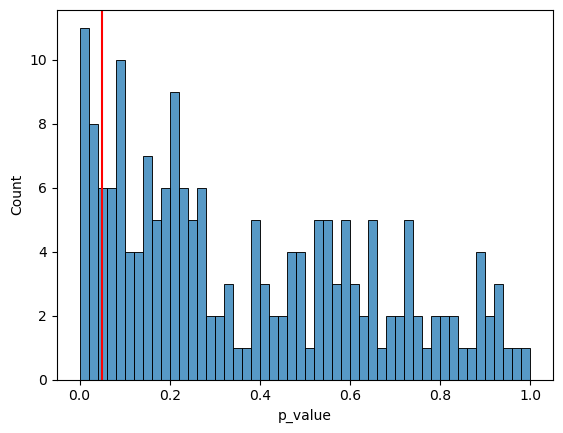

In [18]:
sns.histplot(edist_df, x='p_value', bins=50)
plt.axvline(x=0.05, color='red')

<Axes: xlabel='e_distance', ylabel='Count'>

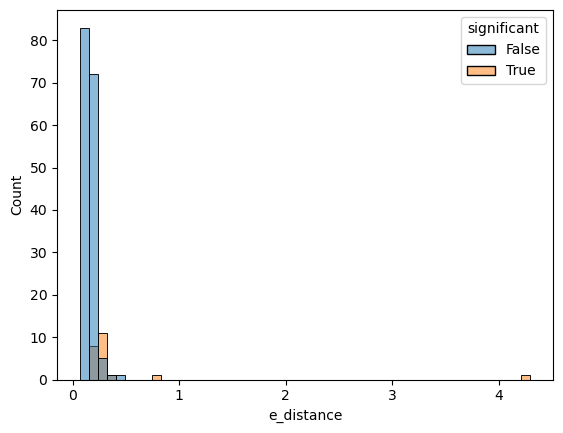

In [19]:
sns.histplot(edist_df, x='e_distance', hue='significant', bins=50)

## Alternative: other distance metrics

In [83]:
sc.tl.rank_genes_groups(adata, groupby='gene_list', reference='control', method='t-test')

/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/users/thiemea/micromamba/envs/nen_env/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:460: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In [84]:
# Number of top genes to consider
n_top_genes = 20

# Extract the gene names for each group
rank_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(n_top_genes)
rank_genes

,ENSG00000137845,ENSG00000185736,ENSG00000141385,ENSG00000156709,ENSG00000127914,ENSG00000159461,ENSG00000160746,ENSG00000183020,ENSG00000100823,ENSG00000049618,...,ENSG00000143952,ENSG00000196998,ENSG00000158023,ENSG00000186153,ENSG00000101966,ENSG00000073050,ENSG00000134684,ENSG00000188994,ENSG00000166716,ENSG00000153896
0,NR2F1,UNC80,NHLRC3,APBB2,FAM184A,NHLRC3,GTF2H2,LNPK,PPFIA2,SGIP1,...,ID2,KMT2B,RPL10,RPF2,SYT4,RRAGB,LCORL,SYT1,MTMR4,IRX3
1,IGFBP2,WDR70,GTF2H2,CEP290,BRINP3,CASKIN1,KLHL34,GNB3,ZNF528,ERBB4,...,NHLRC3,GSE1,RPS27,SPAG16,KITLG,KLHL29,ESF1,CRABP2,TNRC6C,DMWD
2,N4BP2L2,CLVS2,SAMD5,KCNQ1OT1,LUZP2,PHKG1,SPIN2A,BRSK2,UBE2QL1,ANAPC7,...,AC008522.1,NNAT,ZNF397,UBE2QL1,PPFIA2,UBE2QL1,TANC2,UNC13A,ECM1,CARHSP1
3,PPP4R4,STARD4-AS1,KCNJ6,GABPB1-AS1,ITGBL1,GTF2H2,CAMK1D,ZNF7,DCBLD2,LPAR2,...,CIC,KCNJ6,VIPR2,RRAGB,YIPF4,MTMR4,PTPRN,APP,DNAJC22,SRRM3
4,PTTG1,CACNB4,N4BP2L2,DLG2,SGK494,BIRC6,RIMS2,NPIPB5,EHMT1,GTF2H2,...,KCNJ6,PRKCB,PIK3R3,MEF2C,DCBLD2,WLS,CCDC186,PAX2,WDR70,RAPGEF6
5,HMGB2,CHD6,DIP2C,CCNL1,MDK,YIPF4,CLVS2,CCNT2,ULK4,NPHP3,...,PPP6R2,MTHFD2,AFF3,NGFR,EBF3,AC021504.1,TH,DNAJC22,MTRNR2L8,XRRA1
6,TTYH1,SPATA6,HGSNAT,AC092683.1,TENT5A,FSTL5,RPF2,NFATC2IP,SNCA,MTHFD2,...,ZIC2,ZNF432,PTPRG,KCNC1,KSR1,ZNF385D,LNPK,CEP78,CRNDE,ANKRD45
7,FAM184A,ADAR,FABP5,AL590705.1,PRKCB,CTNNB1,AL023284.4,NDST4,CALY,SCN2A,...,TTC7A,CASKIN1,UBE2QL1,DPY19L2,CCNL1,PCLAF,GTF2H2,LPAR2,PILRA,TTYH3
8,PTN,ELF2,P4HA3,CCDC136,DCBLD2,WSB1,HGSNAT,STX18-AS1,SMC2,TTLL7,...,PILRA,MCF2L,STK4,ZGLP1,WLS,THSD7A,NEAT1,DHDDS,AL080317.2,CIC
9,CCNA2,CALD1,AC006480.2,MFSD14C,GLRA2,FAM184A,RFX1,AC142472.1,TAOK3,KMT2B,...,AL023284.4,AL450384.2,CCDC186,WDFY3,POU2F2,LRRN3,FAM184A,CEBPG,CYB5R4,CCND2


In [85]:
perturbation_scores = {}

for group in rank_genes.columns:
    # Get the top marker genes for this group
    marker_genes = rank_genes[group].dropna().values
    marker_genes = [gene for gene in marker_genes if gene in adata.var_names]
    print(group)
    
    if not marker_genes:
        perturbation_scores[group] = np.nan
        continue

    # Get perturbed and control cells
    perturbed_cells = adata.obs['gene_list'] == group
    control_cells = adata.obs['gene_list'] == 'control'

    # Extract expression
    perturbed_expr = adata[perturbed_cells, marker_genes].X
    control_expr = adata[control_cells, marker_genes].X

    print(perturbed_expr.shape)

    # Convert if sparse
    if not isinstance(perturbed_expr, np.ndarray):
        perturbed_expr = perturbed_expr.toarray()
    if not isinstance(control_expr, np.ndarray):
        control_expr = control_expr.toarray()

    # Mean expression across marker genes and cells
    perturbed_mean = np.mean(perturbed_expr, axis=0)
    control_mean = np.mean(control_expr, axis=0)

    # Calculate perturbation score: e.g., difference or log2 fold change
    #score = float(np.abs(perturbed_mean - control_mean).mean())

    #score = np.mean([wasserstein_distance(perturbed_expr[:, i], control_expr[:, i]) for i in range(perturbed_expr.shape[1])])

    gene_std = np.std(control_expr, axis=0) + 1e-6  # avoid div by zero
    z_scores = (perturbed_mean - control_mean) / gene_std
    score = np.abs(z_scores).mean()

    # score = np.log2((perturbed_mean + 1e-6) / (control_mean + 1e-6))  # alternative
    perturbation_scores[group] = score
    perturbation_scores = pd.Series(perturbation_scores)
    perturbation_scores.name = 'perturbation_scores'

ENSG00000137845
(181, 20)
ENSG00000185736
(137, 20)
ENSG00000141385
(181, 20)
ENSG00000156709
(145, 20)
ENSG00000127914
(165, 20)
ENSG00000159461
(120, 20)
ENSG00000160746
(226, 20)
ENSG00000183020
(239, 20)
ENSG00000100823
(161, 20)
ENSG00000049618
(160, 20)
ENSG00000057663
(119, 20)
ENSG00000105409
(205, 20)
ENSG00000165629
(111, 20)
ENSG00000167863
(152, 20)
ENSG00000182220
(204, 20)
ENSG00000124788
(188, 20)
ENSG00000163635
(153, 20)
ENSG00000130638
(140, 20)
ENSG00000087088
(178, 20)
ENSG00000074582
(149, 20)
ENSG00000126581
(234, 20)
ENSG00000136717
(145, 20)
ENSG00000108578
(109, 20)
ENSG00000113734
(168, 20)
ENSG00000104327
(152, 20)
ENSG00000164305
(244, 20)
ENSG00000163171
(143, 20)
ENSG00000140937
(125, 20)
ENSG00000149187
(149, 20)
ENSG00000182923
(232, 20)
ENSG00000100075
(197, 20)
ENSG00000174469
(137, 20)
ENSG00000068120
(180, 20)
ENSG00000103051
(169, 20)
ENSG00000006695
(203, 20)
ENSG00000014919
(154, 20)
ENSG00000005339
(324, 20)
ENSG00000117984
(120, 20)
ENSG00000008

(array([1., 0., 1., 2., 1., 1., 1., 0., 2., 4., 4., 4., 1., 6., 7., 9., 5.,
        2., 4., 8., 8., 9., 6., 2., 8., 2., 2., 4., 6., 9., 4., 5., 3., 5.,
        4., 4., 4., 3., 2., 1., 1., 3., 0., 2., 4., 1., 1., 0., 0., 1., 1.,
        2., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([0.21883003, 0.22102354, 0.22321707, 0.22541058, 0.22760409,
        0.22979762, 0.23199113, 0.23418464, 0.23637816, 0.23857167,
        0.24076518, 0.24295869, 0.24515222, 0.24734573, 0.24953924,
        0.25173277, 0.25392628, 0.25611979, 0.2583133 , 0.26050681,
        0.26270035, 0.26489386, 0.26708737, 0.26928088, 0.27147439,
        0.2736679 , 0.27586144, 0.27805495, 0.28024846, 0.28244197,
        0.28463548, 0.28682899, 0.28902251, 0.29121605, 0.29340956,
        0.29560307, 0.29779658, 0.29999009, 0.30218363, 0.30437714,
      

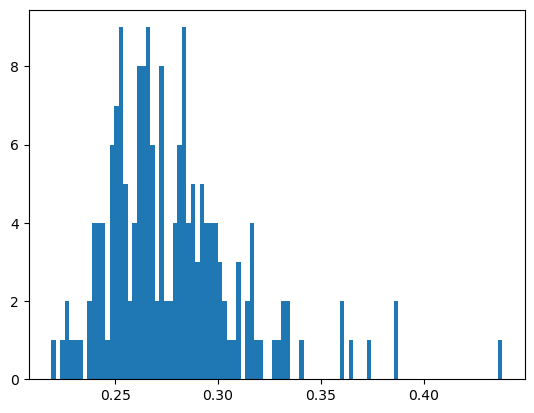

In [86]:
perturbation_scores = pd.Series(perturbation_scores)
plt.hist(perturbation_scores[perturbation_scores < 20], bins=100)

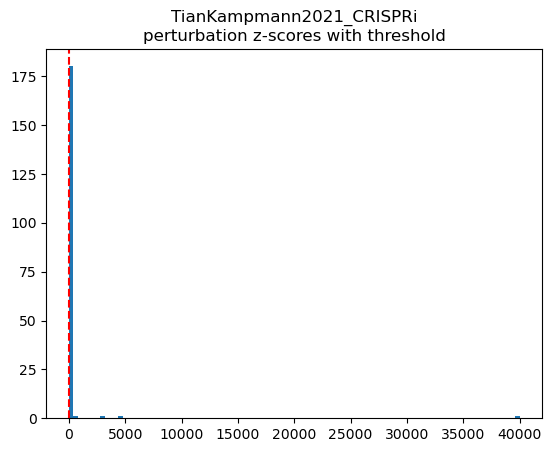

In [87]:
cutoff = 0.25

plt.hist(perturbation_scores, bins=100)
plt.axvline(cutoff, color='red', linestyle='--')
plt.title(f'{perturbation_screen_name}\nperturbation z-scores with threshold')
plt.savefig(f'../figures/preprocessing/z_scores_{perturbation_screen_name}.png', dpi=400)

In [88]:
# Classify cells
perturbation_status = perturbation_scores > cutoff
perturbation_status.name = 'perturbation_status'
print(perturbation_status)
adata.obs = pd.merge(left=adata.obs, right=perturbation_scores, left_on='gene_list', right_index=True, how='outer')
adata.obs = pd.merge(left=adata.obs, right=perturbation_status, left_on='gene_list', right_index=True, how='outer')
adata.obs

ENSG00000137845     True
ENSG00000185736     True
ENSG00000141385     True
ENSG00000156709     True
ENSG00000127914     True
                   ...  
ENSG00000073050    False
ENSG00000134684     True
ENSG00000188994     True
ENSG00000166716     True
ENSG00000153896    False
Name: perturbation_status, Length: 184, dtype: bool


,guide_id,perturbation,tissue_type,celltype,cancer,disease,perturbation_type,organism,batch,nperts,ngenes,ncounts,percent_mito,percent_ribo,percent_hemo,n_genes,gene_list,perturbation_scores,perturbation_status
AAGACAACAGCGTTTA,SARM1_i2,SARM1,primary,iPSC-induced neuron,False,healthy,CRISPR,human,1,1,5167,17733.0,9.479501,6.609147,0.0,5167,ENSG00000004139,0.282747,True
AAGCCATTCGAATGCT,SARM1_i2,SARM1,primary,iPSC-induced neuron,False,healthy,CRISPR,human,1,1,5311,16777.0,3.683614,6.967873,0.0,5311,ENSG00000004139,0.282747,True
AATCACGTCGCTAAAC,SARM1_i2,SARM1,primary,iPSC-induced neuron,False,healthy,CRISPR,human,1,1,4029,11449.0,6.533322,6.716744,0.0,4029,ENSG00000004139,0.282747,True
AATTTCCCACGGCCAT,SARM1_i1,SARM1,primary,iPSC-induced neuron,False,healthy,CRISPR,human,1,1,5016,15883.0,5.546811,5.181641,0.0,5016,ENSG00000004139,0.282747,True
ACAGGGAGTTGCATCA,SARM1_i1,SARM1,primary,iPSC-induced neuron,False,healthy,CRISPR,human,1,1,3453,8636.0,5.280222,7.735063,0.0,3453,ENSG00000004139,0.282747,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTTTCAGGACTAG,non-targeting_00655_i1,control,primary,iPSC-induced neuron,False,healthy,CRISPR,human,4,0,5319,18188.0,7.037607,9.528260,0.0,5319,control,NaN,NaN
TTGTTCAGTGTAAACA,non-targeting_00574_i1,control,primary,iPSC-induced neuron,False,healthy,CRISPR,human,4,0,4065,10626.0,6.446452,6.070017,0.0,4065,control,NaN,NaN
TTTACGTCACTGTCGG,non-targeting_00655_i1,control,primary,iPSC-induced neuron,False,healthy,CRISPR,human,4,0,3974,10514.0,4.441697,6.572189,0.0,3974,control,NaN,NaN
TTTCAGTTCCTAGCTC,non-targeting_00883_i1,control,primary,iPSC-induced neuron,False,healthy,CRISPR,human,4,0,5364,18802.0,4.286778,8.866078,0.0,5364,control,NaN,NaN


In [89]:
adata.obs.columns

Index(['guide_id', 'perturbation', 'tissue_type', 'celltype', 'cancer',
       'disease', 'perturbation_type', 'organism', 'batch', 'nperts', 'ngenes',
       'ncounts', 'percent_mito', 'percent_ribo', 'percent_hemo', 'n_genes',
       'gene_list', 'perturbation_scores', 'perturbation_status'],
      dtype='object')

In [90]:
perturbation_df = pd.DataFrame(columns=['Target', 'Perturbed', 'Cell Line', 'ID', 'Experiment'])

temp_df = adata.obs[(adata.obs['gene_list'] != 'control') & (adata.obs['gene_list'] != '')]

perturbation_df['Target'] = temp_df['gene_list']
perturbation_df['Perturbed'] = temp_df['perturbation_status']
perturbation_df['Cell Line'] = temp_df['celltype']
perturbation_df['ID'] = temp_df.index
perturbation_df['Experiment'] = perturbation_screen_name
perturbation_df

,Target,Perturbed,Cell Line,ID,Experiment
AAGACAACAGCGTTTA,ENSG00000004139,True,iPSC-induced neuron,AAGACAACAGCGTTTA,TianKampmann2021_CRISPRi
AAGCCATTCGAATGCT,ENSG00000004139,True,iPSC-induced neuron,AAGCCATTCGAATGCT,TianKampmann2021_CRISPRi
AATCACGTCGCTAAAC,ENSG00000004139,True,iPSC-induced neuron,AATCACGTCGCTAAAC,TianKampmann2021_CRISPRi
AATTTCCCACGGCCAT,ENSG00000004139,True,iPSC-induced neuron,AATTTCCCACGGCCAT,TianKampmann2021_CRISPRi
ACAGGGAGTTGCATCA,ENSG00000004139,True,iPSC-induced neuron,ACAGGGAGTTGCATCA,TianKampmann2021_CRISPRi
...,...,...,...,...,...
TCATTCATCCGGGACT,ENSG00000291237,True,iPSC-induced neuron,TCATTCATCCGGGACT,TianKampmann2021_CRISPRi
TCATTGTTCCCGAGGT,ENSG00000291237,True,iPSC-induced neuron,TCATTGTTCCCGAGGT,TianKampmann2021_CRISPRi
TGTTCATGTCGACGCT,ENSG00000291237,True,iPSC-induced neuron,TGTTCATGTCGACGCT,TianKampmann2021_CRISPRi
TTACGTTCAGGCTTGC,ENSG00000291237,True,iPSC-induced neuron,TTACGTTCAGGCTTGC,TianKampmann2021_CRISPRi


In [91]:
perturbation_df.to_csv(f'../data/perturbation_screens/{perturbation_screen_name}_processed.csv')

In [16]:
df_expr_ref_celline = pd.read_csv('../data/expression_reference/rna_celline.tsv', sep='\t')
df_expr_ref_cell_type = pd.read_csv('../data/expression_reference/rna_single_cell_type.tsv', sep='\t')

In [17]:
df_expr_ref_cell_type

,Gene,Gene name,Cell type,nTPM
0,ENSG00000000003,TSPAN6,Adipocytes,147.5
1,ENSG00000000003,TSPAN6,Alveolar cells type 1,6.0
2,ENSG00000000003,TSPAN6,Alveolar cells type 2,10.9
3,ENSG00000000003,TSPAN6,Astrocytes,13.6
4,ENSG00000000003,TSPAN6,B-cells,1.5
...,...,...,...,...
1626637,ENSG00000288695,ENSG00000288695,Squamous epithelial cells,0.1
1626638,ENSG00000288695,ENSG00000288695,Suprabasal keratinocytes,0.3
1626639,ENSG00000288695,ENSG00000288695,Syncytiotrophoblasts,0.0
1626640,ENSG00000288695,ENSG00000288695,T-cells,0.1


In [23]:
df_expr_ref = pd.DataFrame(columns = ['Cell Line', 'Gene'])

k562 = {'Cell Line': 'K562', 'Gene': list(df_expr_ref_celline[(df_expr_ref_celline['Cell line'] == 'K-562') & (df_expr_ref_celline['TPM'] > 0.0)]['Gene'].unique())}
df_expr_ref = pd.concat([df_expr_ref, pd.DataFrame(k562)])
melanocytes = {'Cell Line': 'melanocytes', 'Gene': list(df_expr_ref_cell_type[(df_expr_ref_cell_type['Cell type'] == 'Melanocytes') & (df_expr_ref_cell_type['nTPM'] > 0.0)]['Gene'].unique())}
df_expr_ref = pd.concat([df_expr_ref, pd.DataFrame(melanocytes)])
neurons = {'Cell Line': 'iPSC-induced neuron', 'Gene': list(df_expr_ref_cell_type[((df_expr_ref_cell_type['Cell type'] == 'Excitatory neurons') | (df_expr_ref_cell_type['Cell type'] == 'Inhibitory neurons')) & (df_expr_ref_cell_type['nTPM'] > 0.0)]['Gene'].unique())}
df_expr_ref = pd.concat([df_expr_ref, pd.DataFrame(neurons)])

df_expr_ref

,Cell Line,Gene
0,K562,ENSG00000000003
1,K562,ENSG00000000419
2,K562,ENSG00000000457
3,K562,ENSG00000000460
4,K562,ENSG00000000938
...,...,...
16470,iPSC-induced neuron,ENSG00000286219
16471,iPSC-induced neuron,ENSG00000286237
16472,iPSC-induced neuron,ENSG00000287542
16473,iPSC-induced neuron,ENSG00000288602


In [24]:
df_expr_ref['Gene'].value_counts()

Gene
ENSG00000285437    3
ENSG00000285053    3
ENSG00000003249    3
ENSG00000003147    3
ENSG00000003137    3
                  ..
ENSG00000282757    1
ENSG00000281991    1
ENSG00000280709    1
ENSG00000280165    1
ENSG00000279408    1
Name: count, Length: 18097, dtype: int64

<Axes: xlabel='count', ylabel='Count'>

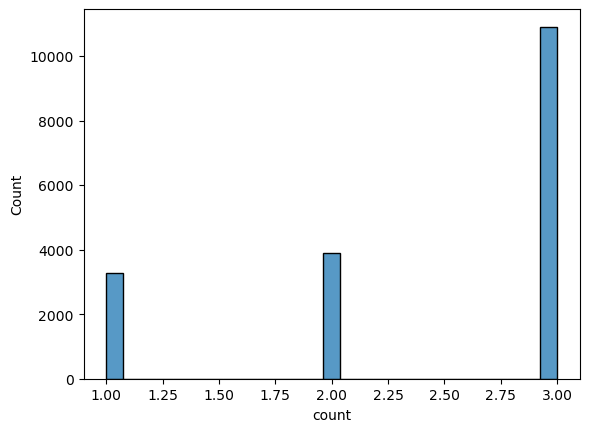

In [28]:
sns.histplot(df_expr_ref['Gene'].value_counts())

In [29]:
df_expr_ref.to_csv('../data/expression_reference/expression_reference.csv')